In [39]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import logging
import datetime
import WazeRouteCalculator
from multiprocessing import Pool, cpu_count
import seaborn as sns


In [15]:
######### Logger Inicio
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
log_filename = f"logs/SanBorjaEdgesWaze0800_{timestamp}.log"

logging.basicConfig(
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')
logger = logging.getLogger()

fileHandler = logging.FileHandler(log_filename)
fileHandler.setFormatter(logFormatter)
logger.addHandler(fileHandler)

consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(logFormatter)
logger.addHandler(consoleHandler)

######### Logger Fin

In [2]:
%%time
# place_name = "Lima, Peru"
place_name = ["San Borja, Lima"]
graph = ox.graph_from_place(place_name, which_result=1, network_type='drive')

CPU times: user 6.08 s, sys: 118 ms, total: 6.2 s
Wall time: 1min 10s


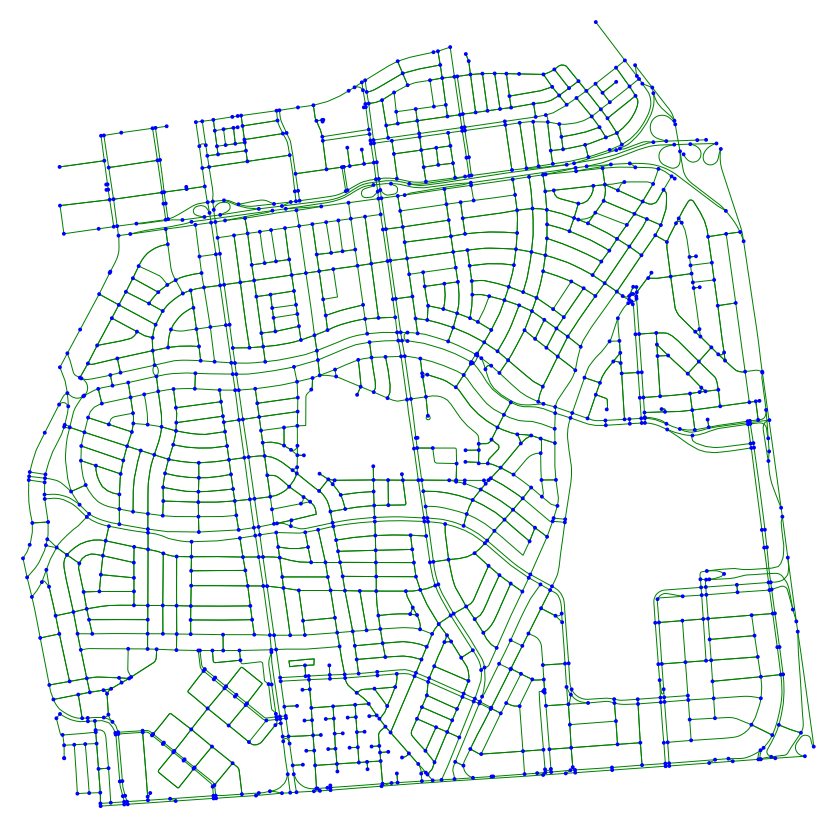

In [3]:
fig, ax = ox.plot_graph(graph, bgcolor='white', node_color='blue', edge_color='green', figsize=(15,15))

In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

In [26]:
nodes.to_csv("data/GrafoSanBorja_nodes.csv")
edges.to_csv("data/GrafoSanBorja_edges.csv")

In [27]:
!ls

cache				  nohup.out
data				  RutasLima_2.ipynb
EdgesWaze.py			  RutasLima_3.ipynb
img				  RutasLima4.ipynb
LimaEdgesWaze0800_Final.txt	  RutasLima.ipynb
LimaEdgesWaze0800_Recupero01.txt  RutasLimaTemp.ipynb
LimaEdgesWaze0800_Recupero02.txt  RutasLimaWaze_parte01.txt
LimaEdgesWaze0800_Recupero03.txt  RutasLimaWaze_parte02.txt
LimaEdgesWaze0800_Recupero04.txt  RutasLimaWaze_recupero1.txt
LimaEdgesWaze0800.txt		  RutasLimaWaze_recupero2.txt
LimaEdgesWaze1400-Copy1.txt	  RutasLimaWaze_recupero3.txt
LimaEdgesWaze1400_Final.txt	  RutasLimaWaze.txt
LimaEdgesWaze1400_Recupero01.txt  RutasLimaWaze_x.txt
LimaEdgesWaze1400_Recupero02.txt  SanBorjaEdgesWaze0800_Recupero01.txt
LimaEdgesWaze1400_Recupero03.txt  SanBorjaEdgesWaze1000_Recupero01.txt
LimaEdgesWaze1400_Recupero04.txt  SanBorjaEdgesWaze1400_Recupero01.txt
LimaEdgesWaze1400.txt		  SanBorjaEdgesWaze1800_Recupero01.txt
logs				  SanBorja.ipynb


In [31]:
horarios = ['0800', '1000', '1400', '1800']

sanborja_dfs = []

for h in horarios:
    file = f'SanBorjaEdgesWaze{h}_Recupero01.txt'
    df = pd.read_csv(file, sep=';', index_col=0,names=['u','v','wazeinfo'])
    df['horario'] = h
    sanborja_dfs.append(df)

In [37]:
sanborja = pd.concat(sanborja_dfs)
sanborja['minutes'] = sanborja.apply(lambda x: x['wazeinfo'].replace('(','').replace(')','').split(',')[0], axis=1)
sanborja['km'] = sanborja.apply(lambda x: x['wazeinfo'].replace('(','').replace(')','').split(',')[1], axis=1)
sanborja[['minutes', 'km']] = sanborja[['minutes', 'km']].astype(float)


In [38]:
sanborja


,u,v,wazeinfo,horario,minutes,km
0,182472511,4352753162,"(-1, -1)",0800,-1.000000,-1.000
100,391036748,417252192,"(-1, -1)",0800,-1.000000,-1.000
1500,417251186,417251188,"(-1, -1)",0800,-1.000000,-1.000
2700,3352889094,412554377,"(-1, -1)",0800,-1.000000,-1.000
300,392148937,4808012581,"(-1, -1)",0800,-1.000000,-1.000
...,...,...,...,...,...,...
996,416953775,416953778,"(0.0, 0.0)",1800,0.000000,0.000
997,416953778,416953775,"(0.08333333333333333, 0.044)",1800,0.083333,0.044
998,416953778,416953793,"(0.0, 0.0)",1800,0.000000,0.000
1999,485622400,485622720,"(0.0, 0.001)",1800,0.000000,0.001


In [48]:
cond = sanborja['minutes'] > 0
sanborja[cond]

,u,v,wazeinfo,horario,minutes,km
1200,417248093,417248095,"(0.016666666666666666, 0.011)",0800,0.016667,0.011
1100,416965982,416965913,"(0.016666666666666666, 0.008)",0800,0.016667,0.008
500,412528269,412528265,"(0.3333333333333333, 0.068)",0800,0.333333,0.068
400,392152691,391037982,"(0.3333333333333333, 0.172)",0800,0.333333,0.172
701,412557537,412557552,"(0.45, 0.118)",0800,0.450000,0.118
...,...,...,...,...,...,...
991,416953771,416953806,"(0.25, 0.063)",1800,0.250000,0.063
1998,485622354,485622344,"(0.35, 0.167)",1800,0.350000,0.167
993,416953771,416953775,"(0.03333333333333333, 0.02)",1800,0.033333,0.020
994,416953771,416660447,"(0.3, 0.128)",1800,0.300000,0.128


In [67]:
sanborja[cond].groupby('horario').describe()[['minutes', 'km']]

minutes                                                              \
          count      mean       std       min       25%       50%       75%   
horario                                                                       
0800      908.0  0.316924  0.503730  0.016667  0.100000  0.191667  0.333333   
1000     1603.0  0.331743  0.531107  0.016667  0.100000  0.200000  0.350000   
1400     1581.0  0.321126  0.517044  0.016667  0.116667  0.200000  0.350000   
1800     1593.0  0.346788  0.550221  0.016667  0.116667  0.200000  0.366667   

                       km                                                    \
              max   count      mean       std    min    25%    50%      75%   
horario                                                                       
0800     7.366667   908.0  0.104764  0.208459  0.001  0.041  0.067  0.11825   
1000     8.283333  1603.0  0.103708  0.185882  0.000  0.041  0.066  0.12300   
1400     8.883333  1581.0  0.102715  0.195230  0.001  0.041  0.066  0.12300   
1800     7.800000  1593.0  0.105943  0.188774  0.000  0.043  0.066  0.12500   

                
           max  
horario         
0800     3.760  
1000     3.760  
1400     5.040  
1800     3.767

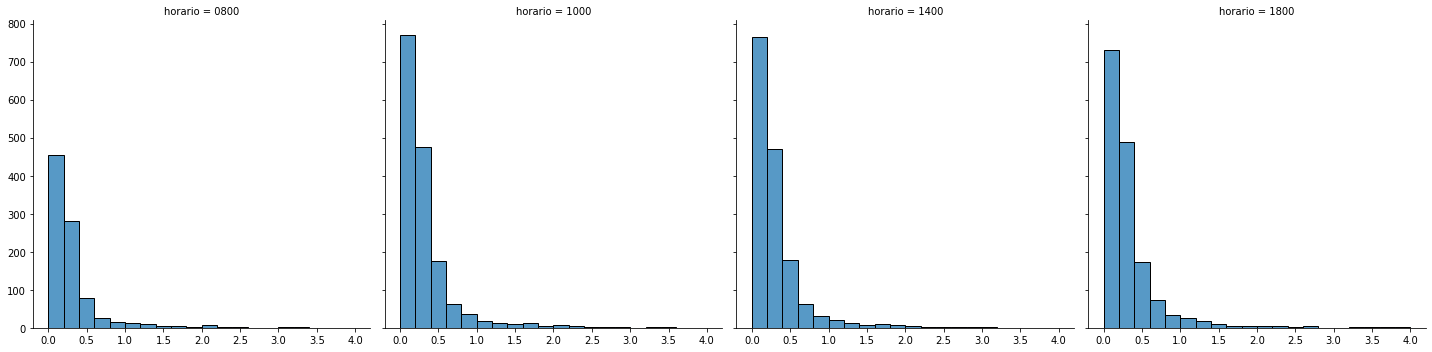

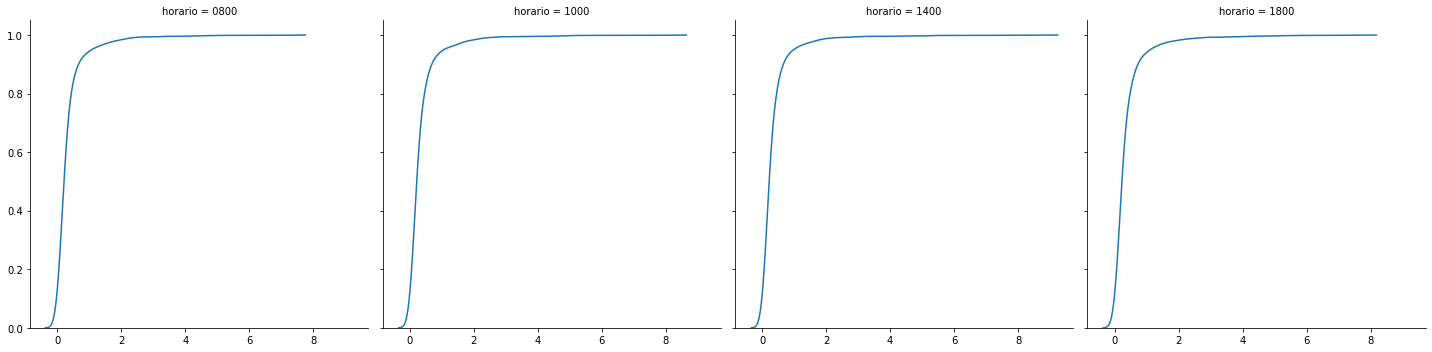

In [83]:
# fig, ax = plt.subplots(figsize=(15,7))

g = sns.FacetGrid(sanborja[cond], col="horario", height=5, aspect=1)
g.map_dataframe(sns.histplot, x="minutes", binwidth=0.2, binrange=(0, 4))
plt.show()
g = sns.FacetGrid(sanborja[cond], col="horario", height=5, aspect=1)
g.map_dataframe(sns.kdeplot, x="minutes", cumulative=True )
plt.show()

<AxesSubplot:xlabel='minutes', ylabel='Density'>

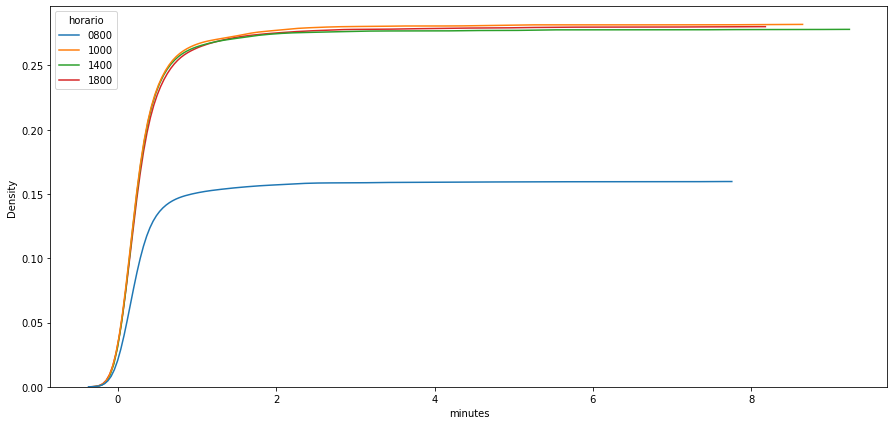

In [62]:
fig, ax = plt.subplots(figsize=(15,7))
# sns.histplot(sanborja[cond], x='minutes' , hue='horario', log_scale=True, ax=ax, kde=True)
sns.kdeplot(data=sanborja[cond], x='minutes', cumulative=True, hue='horario')


<AxesSubplot:xlabel='horario', ylabel='minutes'>

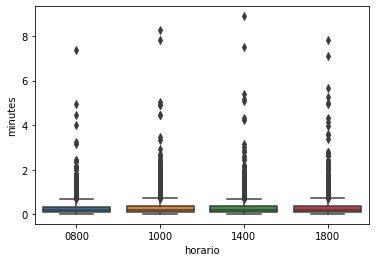

In [56]:
sns.boxplot(data=sanborja[cond], x='horario', y='minutes', )